# RAPIDS - Feature Engineering - 1st Place Fraud Comp - [0.96]
The secret to creating a high scoring model in Kaggle's IEEE CIS Fraud Competition is feature engineering. A list of feature engineering techniques is posted [here][1]. The most important features in Fraud Comp are new columns created from group aggregations of other columns. Why this works is explained [here][2]. Computing group aggregations can naturally be done in parallel and benefit from using GPU instead of CPU.

This notebook contains the XGBoost model of the 1st place Fraud Comp solution converted to use RAPIDS cuDF. (The entire 1st place solution is an ensemble of XGBoost, CatBoost, and LightGBM with additional post processing described [here][4]). To read one million rows from disk and create 262 features on CPU using Pandas takes 5 minutes. To read and create those features on GPU with RAPIDS cuDF takes 20 seconds as shown below. RAPIDS is 15x faster!

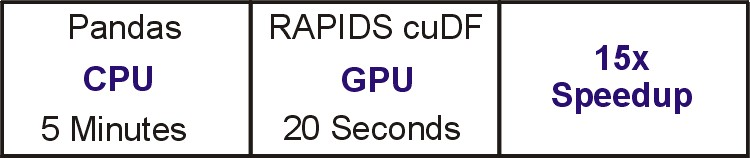

Individual GPU times are listed beneath code blocks below. Pandas CPU times are displayed in the notebook [here][3] beneath code blocks.

[1]: https://www.kaggle.com/c/ieee-fraud-detection/discussion/108575
[2]: https://www.kaggle.com/c/ieee-fraud-detection/discussion/111453
[3]: https://www.kaggle.com/cdeotte/xgb-fraud-with-magic-0-9600
[4]: https://www.kaggle.com/c/ieee-fraud-detection/discussion/111284

# Install RAPIDS
Here we install RAPIDS from a Kaggle dataset taking 1 minute. (Install from Conda shown [here][1], if this doesn't work).

[1]: https://www.kaggle.com/cdeotte/rapids-data-augmentation-mnist-0-985

In [ ]:
%%time
# INSTALL RAPIDS OFFLINE (FROM KAGGLE DATASET). TAKES 1 MINUTE :-)
import sys
!cp ../input/rapids/rapids.0.11.0 /opt/conda/envs/rapids.tar.gz
!cd /opt/conda/envs/ && tar -xzvf rapids.tar.gz
sys.path = ["/opt/conda/envs/rapids/lib"] + ["/opt/conda/envs/rapids/lib/python3.6"] + ["/opt/conda/envs/rapids/lib/python3.6/site-packages"] + sys.path
!cp /opt/conda/envs/rapids/lib/libxgboost.so /opt/conda/lib/

In [ ]:
import cudf, cupy, math, warnings, time 
from numba import cuda, float32, int8
import numpy as np, pandas as pd, os, gc
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

LOCAL_VALIDATION = False

# LIST COLUMNS TO LOAD
cols = ['TransactionID', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain',
       'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
       'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8',
       'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4',
       'M5', 'M6', 'M7', 'M8', 'M9']
# USEFUL V COLUMNS
v =  [1, 3, 4, 6, 8, 11]
v += [13, 14, 17, 20, 23, 26, 27, 30]
v += [36, 37, 40, 41, 44, 47, 48]
v += [54, 56, 59, 62, 65, 67, 68, 70]
v += [76, 78, 80, 82, 86, 88, 89, 91]
v += [107, 108, 111, 115, 117, 120, 121, 123] 
v += [124, 127, 129, 130, 136] 
v += [138, 139, 142, 147, 156, 162] 
v += [165, 160, 166] 
v += [178, 176, 173, 182] 
v += [187, 203, 205, 207, 215] 
v += [169, 171, 175, 180, 185, 188, 198, 210, 209] 
v += [218, 223, 224, 226, 228, 229, 235] 
v += [240, 258, 257, 253, 252, 260, 261] 
v += [264, 266, 267, 274, 277] 
v += [220, 221, 234, 238, 250, 271] 
v += [294, 284, 285, 286, 291, 297] 
v += [303, 305, 307, 309, 310, 320] 
v += [281, 283, 289, 296, 301, 314] 
cols += ['V'+str(x) for x in v]

# DECLARE COLUMN DTYPES
dtypes = {'isFraud':'int8'}
for c in cols+['id_0'+str(x) for x in range(1,10)]+['id_'+str(x) for x in range(10,34)]: dtypes[c] = 'float32'
for c in ['id-0'+str(x) for x in range(1,10)]+['id-'+str(x) for x in range(10,34)]: dtypes[c] = 'float32'
str_type = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain','M1', 'M2', 'M3', 'M4','M5',
            'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 
            'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']
str_type += ['id-12', 'id-15', 'id-16', 'id-23', 'id-27', 'id-28', 'id-29', 'id-30', 
            'id-31', 'id-33', 'id-34', 'id-35', 'id-36', 'id-37', 'id-38']
for c in str_type: dtypes[c] = 'category'
#for c in str_type: dtypes[c] = 'str'

start = time.time()
print('RAPIDS =',cudf.__version__)

# GPU Load Data
Here we read the data from the disk with cuDF directly into the GPU. With CPU Pandas this takes 46 seconds. With GPU RAPIDS this takes 4.7 seconds! 

In [ ]:
%%time
# LOAD TRAIN
X_train = cudf.read_csv('../input/ieee-fraud-detection/train_transaction.csv',index_col='TransactionID', usecols=cols+['isFraud'],dtype=dtypes)
train_id = cudf.read_csv('../input/ieee-fraud-detection/train_identity.csv',index_col='TransactionID',dtype=dtypes)
X_train = X_train.merge(train_id, how='left', left_index=True, right_index=True)
# LOAD TEST
X_test = cudf.read_csv('../input/ieee-fraud-detection/test_transaction.csv',index_col='TransactionID', usecols=cols,dtype=dtypes)
test_id = cudf.read_csv('../input/ieee-fraud-detection/test_identity.csv',index_col='TransactionID', dtype=dtypes)
fix = {o:n for o, n in zip(test_id.columns, train_id.columns)}
test_id.rename(columns=fix, inplace=True)
X_test = X_test.merge(test_id, how='left', left_index=True, right_index=True)
# PRINT SHAPE
del train_id, test_id; x = gc.collect()
print('Train shape on GPU',X_train.shape,'Test shape on GPU',X_test.shape)

# GPU Preprocess
First we normalize D Columns, label encode all categorical columns, shift numerics postive, and fill NaN with -1. Note that RAPIDS cuDF has already label encoded all the categorical variables when they were read from disk if `dtype='category'` was used instead of `dtype='str'`.

In [ ]:
%%time
# NORMALIZE D COLUMNS
for i in range(1,16):
    if i in [1,2,3,5,9]: continue
    X_train['D'+str(i)] =  X_train['D'+str(i)] - X_train.TransactionDT/np.float32(24*60*60)
    X_test['D'+str(i)] = X_test['D'+str(i)] - X_test.TransactionDT/np.float32(24*60*60) 
       
# LABEL ENCODE
def encode_LE(df1,df2,col,verbose=True):
    df_comb = cudf.concat([df1[col],df2[col]],axis=0)
    df_comb,_ = df_comb.factorize()
    df1[col] = df_comb[:len(df1)].astype('int32')
    df2[col] = df_comb[len(df1):].astype('int32')
    if verbose: print(col,', ',end='')
        
# SET NAN to -1
for i,f in enumerate(X_train.columns):
    # FACTORIZE CATEGORICAL VARIABLES. SET NAN to -1
    if (X_train[f].dtype=='object'): 
        encode_LE(X_train,X_test,f,False)
    elif f in str_type:
        X_train[f].fillna(-1,inplace=True)
        X_test[f].fillna(-1,inplace=True)
    # SHIFT ALL NUMERICS POSITIVE. SET NAN to -1
    elif f not in ['TransactionAmt','TransactionDT','isFraud']:
        mn = np.min((X_train[f].min(),X_test[f].min()))
        X_train[f] -= np.float32(mn)
        X_test[f] -= np.float32(mn)
        X_train[f].fillna(-1,inplace=True)
        X_test[f].fillna(-1,inplace=True)

# GPU Encoding Functions
The following four functions are Numba CUDA JIT kernels. These functions are optimized to use Nvidia GPU. We will use these together with RAPIDS cuDF's `groupyby(col,method='cudf').apply_grouped(func)` to create blazingly fast custom feature engineering functions! Tutorials about this are [here][1], [here][2], and [here][3].

[1]: https://rapidsai.github.io/projects/cudf/en/0.11.0/guide-to-udfs.html
[2]: https://github.com/daxiongshu/notebooks-extended/blob/kdd_plasticc/advanced_notebooks/tutorials/rapids_customized_kernels.ipynb
[3]: https://numba.pydata.org/numba-doc/latest/cuda/index.html

In [ ]:
def mean2(x,y_out):
    # ALLOCATE SHARED MEMORY
    sum = cuda.shared.array((2),dtype=float32)
    sum[0] = 0; sum[1] = 0
    cuda.syncthreads()
    # COMPUTE SUM AND SKIP NULL
    for i in range(cuda.threadIdx.x,len(x),cuda.blockDim.x):
        if (x[i]!=-1): cuda.atomic.add(sum,0,x[i])
        else: cuda.atomic.add(sum,1,1)
    cuda.syncthreads()
    # OUTPUT MEAN WITHOUT NULL
    for i in range(cuda.threadIdx.x,len(x),cuda.blockDim.x):
        if (len(x)-sum[1])<=0: y_out[i] = -1
        else: y_out[i] = sum[0]/(len(x)-sum[1])
        
def std2(x,y_out):
    # ALLOCATE SHARED MEMORY
    sum = cuda.shared.array((3),dtype=float32)
    for i in range(3): sum[i] = 0
    cuda.syncthreads()
    # COMPUTE MEAN AND SKIP NULL
    for i in range(cuda.threadIdx.x,len(x),cuda.blockDim.x):
        if (x[i]!=-1): cuda.atomic.add(sum,0,x[i])
        else: cuda.atomic.add(sum,2,1)
    cuda.syncthreads()
    if cuda.threadIdx.x==0: sum[0] = sum[0]/(len(x)-sum[2])
    cuda.syncthreads()
    # COMPUTE SUM OF SQUARES AND SKIP NULL
    for i in range(cuda.threadIdx.x,len(x),cuda.blockDim.x):
        if (x[i]!=-1): cuda.atomic.add(sum,1,(x[i]-sum[0])**2) 
    cuda.syncthreads()
    # OUTPUT STANDARD DEVIATION WITHOUT NULL
    for i in range(cuda.threadIdx.x,len(x),cuda.blockDim.x):
        if (len(x)-sum[2])<=1: y_out[i] = -1
        else: y_out[i] = math.sqrt( sum[1]/(len(x)-sum[2]-1) )
            
def count2(x,y_out):
    for i in range(cuda.threadIdx.x,len(x),cuda.blockDim.x):  
        y_out[i] = len(x)
        
def nunique2(x,y_out):
    # ALLOCATE SHARED MEMORY
    record = cuda.shared.array((2048),dtype=int8)
    for i in range(2048): record[i] = 0
    cuda.syncthreads()
    # RECORD UNIQUES
    for i in range(cuda.threadIdx.x,len(x),cuda.blockDim.x):
        record[ int(x[i]*1e6)%2048 ] = 1
    cuda.syncthreads()
    # OUTPUT NUNIQUE
    sum = 0
    for j in range(2048): sum = sum + record[j]
    for i in range(cuda.threadIdx.x,len(x),cuda.blockDim.x):
        y_out[i] = sum

In [ ]:
# GROUP AGGREGATIONS
def add_feature(df1,df2,uid,col,agg,verbose=True):
    if agg=='count': func = count2
    elif agg=='mean': func = mean2
    elif agg=='std' : func = std2
    elif agg=='nunique': func = nunique2
    else: return
    df1['idx'] = np.arange(len(df1))
    df2['idx'] = np.arange(len(df2))+len(df1)
    temp_df = cudf.concat([df1[[uid,col,'idx']], df2[[uid,col,'idx']]])
    tmp = temp_df.groupby(uid,method='cudf').apply_grouped(
        func,
        incols={col:'x'},
        outcols=dict(y_out=np.float32),
        tpb=32
    ).rename({'y_out':'new'})  
    tmp = tmp.sort_values('idx')
    df1[uid+'_'+col+'_'+agg] = tmp.iloc[:len(df1)].new
    df2[uid+'_'+col+'_'+agg] = tmp.iloc[len(df1):].new
    if verbose: print(uid+'_'+col+'_'+agg,', ',end='')
    df1.drop_column('idx')
    df2.drop_column('idx')
    
def add_features(df1,df2,uids,cols,aggs,verbose=True):
    for col in cols:
        for uid in uids:
            for agg in aggs:
                add_feature(df1,df2,uid,col,agg,verbose)
                
# COMBINE FEATURES
def encode_CB(df1,df2,col1,col2,verbose=True):
    nm = col1+'_'+col2
    df1[nm] = df1[col1].astype(str)+'_'+df1[col2].astype(str)
    df2[nm] = df2[col1].astype(str)+'_'+df2[col2].astype(str) 
    encode_LE(df1,df2,nm,verbose=False)
    if verbose: print(nm,', ',end='')

# GPU Feature Engineering
Below is where we create all our new engineered features. The work below takes 10 seconds. The work above took 10 seconds. Using RAPIDS GPU is 15x faster than Pandas CPU.

In [ ]:
%%time
# TRANSACTION AMT CENTS
X_train['cents'] = (X_train['TransactionAmt'] - X_train['TransactionAmt'].floor()).astype('float32')
X_test['cents'] = (X_test['TransactionAmt'] - X_test['TransactionAmt'].floor()).astype('float32')
print('cents, ', end='')
# FREQUENCY ENCODE
add_features(X_train,X_test,['addr1','card1','card2','card3','P_emaildomain'],['TransactionDT'],['count'])
# COMBINE COLUMNS 
encode_CB(X_train,X_test,'card1','addr1')
encode_CB(X_train,X_test,'card1_addr1','P_emaildomain')
# FREQUENCY ENCODE
add_features(X_train,X_test,['card1_addr1','card1_addr1_P_emaildomain'],['TransactionDT'],['count'])
# GROUP AGGREGATE
add_features(X_train,X_test,['card1','card1_addr1','card1_addr1_P_emaildomain'],\
    ['TransactionAmt','D9','D11'],['mean','std'])

In [ ]:
import datetime
# ADD MONTH FEATURE
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')
X_train['DT_M'] = X_train['TransactionDT'].to_pandas().map(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
X_train['DT_M'] = (X_train['DT_M'].dt.year-2017)*12 + X_train['DT_M'].dt.month 

X_test['DT_M'] = X_test['TransactionDT'].to_pandas().map(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
X_test['DT_M'] = (X_test['DT_M'].dt.year-2017)*12 + X_test['DT_M'].dt.month 

In [ ]:
# ADD UID FEATURE
X_train['day'] = X_train.TransactionDT / (24*60*60)
X_train['uid'] = X_train.card1_addr1.astype(str)+'_'+(X_train.day-X_train.D1).floor().astype(str)

X_test['day'] = X_test.TransactionDT / (24*60*60)
X_test['uid'] = X_test.card1_addr1.astype(str)+'_'+(X_test.day-X_test.D1).floor().astype(str)
# LABEL ENCODE
encode_LE(X_train,X_test,'uid',verbose=False)

In [ ]:
%%time
# FREQUENCY ENCODE 
add_features(X_train,X_test,['uid'],['TransactionDT'],['count'])
# AGGREGATE 
add_features(X_train,X_test,['uid'],['TransactionAmt','D4','D9','D10','D15'],['mean','std'])
# AGGREGATE
add_features(X_train,X_test,['uid'],['C'+str(x) for x in range(1,15) if x!=3],['mean'])
# AGGREGATE
add_features(X_train,X_test,['uid'],['M'+str(x) for x in range(1,10)],['mean'])

# AGGREGATE 
add_features(X_train,X_test,['uid'],['P_emaildomain','dist1','DT_M','id_02','cents'],['nunique'])
# AGGREGATE
add_features(X_train,X_test,['uid'],['C14'],['std'])
# AGGREGATE 
add_features(X_train,X_test,['uid'],['C13','V314'],['nunique'])
# AGGREATE 
add_features(X_train,X_test,['uid'],['V127','V136','V309','V307','V320'],['nunique'])

In [ ]:
cols = list( X_train.columns )
# REMOVE FEATURES
cols.remove('TransactionDT'); cols.remove('isFraud')
for c in ['D6','D7','D8','D9','D12','D13','D14'] + ['DT_M','day','uid']:
    cols.remove(c)  
# FAILED TIME CONSISTENCY TEST
for c in ['C3','M5','id_08','id_33']:
    cols.remove(c)
for c in ['card4','id_07','id_14','id_21','id_30','id_32','id_34']:
    cols.remove(c)
for c in ['id_'+str(x) for x in range(22,28)]:
    cols.remove(c)

In [ ]:
print('NOW USING THE FOLLOWING',len(cols),'FEATURES.')
print("We read data from disk and created all these features in %.2f seconds!" % (time.time()-start))
np.array(cols)

# Local Holdout Validation

In [ ]:
X_train = X_train.sort_index()
split = 3*len(X_train)//4

In [ ]:
if LOCAL_VALIDATION:
    import xgboost as xgb
    print("XGBoost version:", xgb.__version__)

    xgb_parms = { 
        'n_estimators':2000,
        'max_depth':12, 
        'learning_rate':0.02, 
        'subsample':0.8,
        'colsample_bytree':0.4, 
        'missing':-1, 
        'eval_metric':'auc',
        'objective':'binary:logistic',
        'tree_method':'gpu_hist' 
    }
    train = xgb.DMatrix(data=X_train.iloc[:split][cols],label=X_train.iloc[:split]['isFraud'])
    valid = xgb.DMatrix(data=X_train.iloc[split:][cols],label=X_train.iloc[split:]['isFraud'])
    clf = xgb.train(xgb_parms, dtrain=train,
        num_boost_round=2000,evals=[(train,'train'),(valid,'valid')],
        early_stopping_rounds=100,maximize=True,
        verbose_eval=50)

# Cross Validation and Inference

In [ ]:
import xgboost as xgb
print("XGBoost version:", xgb.__version__)
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score

X_test = X_test.sort_index()
oof = np.zeros(len(X_train))
preds = np.zeros(len(X_test))

skf = GroupKFold(n_splits=6)
for i, (idxT, idxV) in enumerate( skf.split(X_train, X_train.isFraud, groups=X_train['DT_M'].to_pandas()) ):
    month = X_train.iloc[idxV]['DT_M'].iloc[0]
    print('Fold',i,'withholding month',month)
    print(' rows of train =',len(idxT),'rows of holdout =',len(idxV))
        
    xgb_parms = { 
        'max_depth':12, 
        'learning_rate':0.02, 
        'subsample':0.8,
        'colsample_bytree':0.4, 
        'missing':-1, 
        'eval_metric':'auc',
        'objective':'binary:logistic',
        'tree_method':'gpu_hist' 
    }
    train = xgb.DMatrix(data=X_train.iloc[idxT][cols],label=X_train.iloc[idxT]['isFraud'])
    valid = xgb.DMatrix(data=X_train.iloc[idxV][cols],label=X_train.iloc[idxV]['isFraud'])
    clf = xgb.train(xgb_parms, dtrain=train,
        num_boost_round=2000,evals=[(train,'train'),(valid,'valid')],
        early_stopping_rounds=200,maximize=True,
        verbose_eval=100)   
    
    oof[idxV] += clf.predict(valid)
    test = xgb.DMatrix(data=X_test[cols])
    preds += clf.predict(test)/skf.n_splits
    del clf; x=gc.collect()
print('#'*20)
print ('XGB96 OOF CV=',roc_auc_score(X_train.isFraud.to_array(),oof))

In [ ]:
plt.hist(oof,bins=100)
plt.ylim((0,5000))
plt.title('XGB OOF')
plt.show()

X_train['oof'] = oof
X_train = X_train.reset_index()
X_train[['TransactionID','oof']].to_pandas().to_csv('oof_xgb_96.csv')
X_train = X_train.set_index('TransactionID',drop=True)

# Submit to Kaggle
This submission achieves LB 0.960. If we post process these predictions we achieve LB 0.962. If we ensemble these with CatBoost and LGBM models, we achieve LB 0.968.

In [ ]:
sample_submission = pd.read_csv('../input/ieee-fraud-detection/sample_submission.csv')
sample_submission.isFraud = preds
sample_submission.to_csv('sub_xgb_96.csv',index=False)

plt.hist(sample_submission.isFraud,bins=100)
plt.ylim((0,5000))
plt.title('XGB96 Submission')
plt.show()